In [2]:
## Pyro GP tutorial used as starting point:
## https://pyro.ai/examples/gp.html

import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as pdist
import arviz

# Partition observations
X = np.asarray([x / 29 for x in range(1, 31)])
np.random.shuffle(X)
Y = 6 * np.square(X) - np.square(np.sin(6 * np.pi * X)) - 5 * np.power(X, 4) + 3 / 2 + np.random.normal(0.0, 0.01, 30)
Xtrain, Xtest, Ytrain, Ytest = torch.tensor(X[10:]), torch.tensor(X[:10]), torch.tensor(Y[10:]), torch.tensor(Y[:10])

/Users/vic/Desktop/Computer Science/2/PML/Final Project/PMLFinalProject/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Selecting a suitable model

In [3]:
# We chose a GP regression model and the Matern 3/2 kernel. In this setup, we have three hyper-parameters.
# I) The variance of the kernel, II) the lengthscale of the kernel, and III) the gaussian noise of the model.
# We chose to let the gaussian noise be fixed and equal to the noise of our data, while keeping the variance
# and lengthscale of the kernel variable. The prior distrubition we chose is a multivariate normal
# distribution (i.e. we consider the variance and lengthscale as normally distributed), with mean and variance
# based on what seems reasonable for the Matern 3/2 kernel, based on the lecture slides.

# Define model
class MyGPModel():
    def __init__(self, kernel):
        self.kernel = kernel
        
    def __call__(self, xs, ys=None):
        self.kernel.lengthscale = pyro.sample("lengthscale", pdist.LogNormal(0.0, 1.0))
        self.kernel.variance = pyro.sample("variance", pdist.LogNormal(0.0, 1.0))
        self.gp_model =  gp.models.GPRegression(xs, ys, self.kernel, noise=torch.tensor(0.01))
        return self.gp_model.model()

# Define kernel
def kernel(theta):
    return gp.kernels.Matern32(input_dim=1, variance=theta[0], lengthscale=theta[1])

# Define model
def model(xs, ys, kernel):
    return gp.models.GPRegression(xs, ys, kernel, noise=torch.tensor(0.01))

# Computes log-likelihood
def logLikelihood(xs, ys, kernel, theta):
    # See derivation in report
    t1 = 0.5 * torch.transpose(ys, 0, 0) * torch.linalg.inv(kernel.forward(xs)) * ys
    t2 = 0.5 * torch.log(torch.linalg.det(kernel.forward(xs)))
    t3 = 15.0 * torch.log(2 * torch.tensor(np.pi))
    return (- t1 - t2 - t3) * prior.log_prob(theta)

# Pick prior distributions
pyro.clear_param_store()
some_theta = [torch.tensor(1.5),torch.tensor(1)]
k = kernel(some_theta)
gpr = model(Xtrain, Ytrain, k)
gpr.kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0.0, 1.0))

### Compute posterior predictive

In [4]:
optimizer = torch.optim.SGD(gpr.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))

variance = 1.175486445426941
lengthscale = 0.6760812401771545
noise = 0.14770160615444183


### Using NUTS

In [5]:
# Model is GP model from pyro
W = 50 # Number of warmup steps
C = 1 # Number of chains
S = 500 # Number of samples used in prediction
pyro.clear_param_store()
gp_kernel = kernel(some_theta)
# gp_model_nuts = model(Xtrain, Ytrain)
# guide = pyro.infer.autoguide.AutoDelta(model)

gp_model = MyGPModel(gp_kernel)
nuts_kernel = pyro.infer.NUTS(gp_model, jit_compile=False)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=S, num_chains=C, warmup_steps=W)
mcmc.run(Xtrain, Ytrain)

Sample: 100%|██████████| 550/550 [02:56,  3.11it/s, step size=5.26e-02, acc. prob=0.345]


#### Checking quality of samples using arviz

/Users/vic/Desktop/Computer Science/2/PML/Final Project/PMLFinalProject/venv/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lengthscale  0.173  0.036   0.111    0.244      0.004    0.003      71.0   
variance     3.837  2.006   1.102    7.351      0.271    0.193      43.0   

             ess_tail  r_hat  
lengthscale     159.0    NaN  
variance        133.0    NaN  


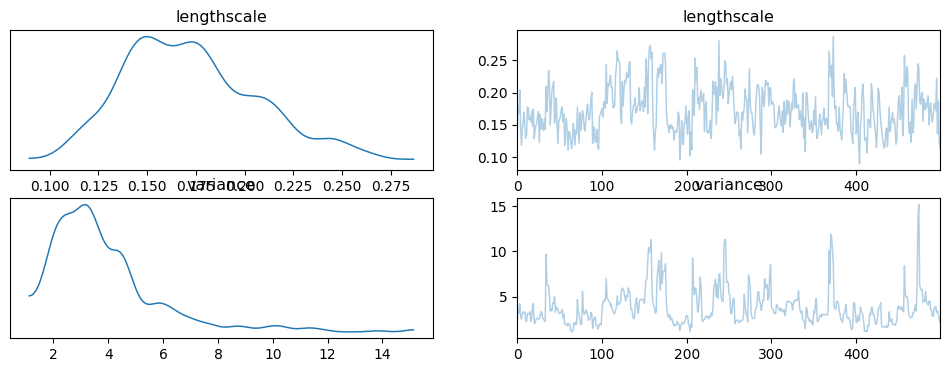

array([<Axes: title={'center': 'lengthscale'}>,
       <Axes: title={'center': 'variance'}>], dtype=object)

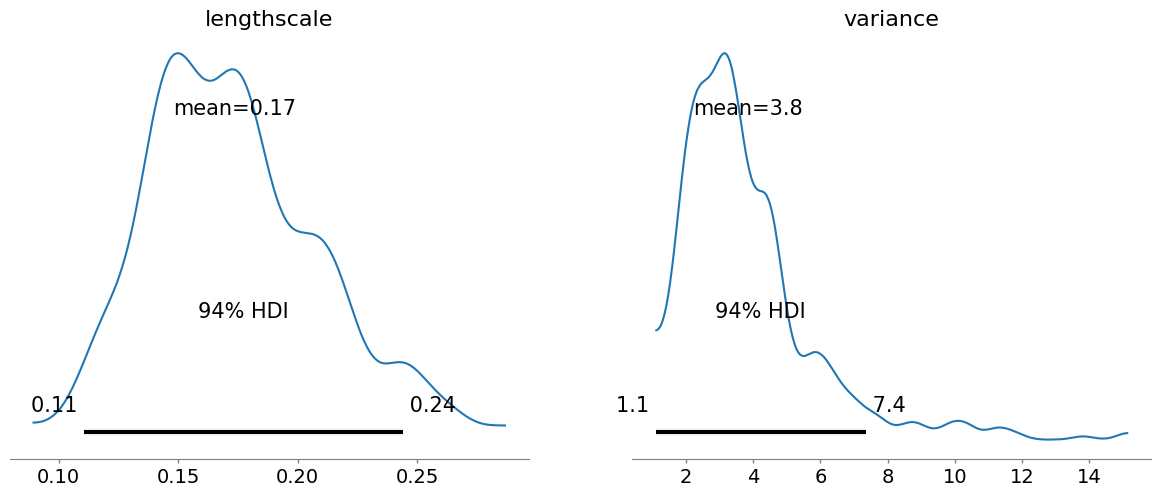

In [6]:
posterior_samples = mcmc.get_samples()
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print(summary)
arviz.plot_trace(data)
plt.show()
arviz.plot_posterior(data)

#### Computing approximate posterior likelihood

In [36]:
def posterior_likelihood(cov_prior, Xtest, Ytest, noise=0.01):
    n = Xtest.shape[0]
    if cov_prior.ndim > 1:
        Xtest = Xtest.repeat(cov_prior.shape[0], 1).T
        parenthesis = noise * torch.eye(n) + Xtest @ cov_prior @ Xtest.T
        mean = cov_prior @ Xtest.T @ torch.linalg.inv(parenthesis) @ Ytest
        sigma = cov_prior - cov_prior @ Xtest.T @ torch.linalg.inv(parenthesis) @ Xtest @ cov_prior
        return mean, sigma
    else:
        parenthesis = noise * torch.eye(n) + Xtest * cov_prior * Xtest.T
        mean = cov_prior * Xtest.T @ torch.linalg.inv(parenthesis) @ Ytest
        sigma = cov_prior - cov_prior * Xtest.T @ torch.linalg.inv(parenthesis) @ Xtest * cov_prior
        return mean, sigma
    

def approximate_univariate_likelihood(posterior_samples, Xtest, Ytest, noise=0.01):
    n = posterior_samples[0]
    mean_result = 0
    sigma_result = 0 
    for sample in posterior_samples:
        mean_i, sigma_i = posterior_likelihood(sample, Xtest, Ytest, noise)
        mean_result += mean_i
        sigma_result += sigma_i

    return mean_result / n, sigma_result / n

def approximate_posterior_likelihood(posterior_samples, Xtest, Ytest, noise=0.01):
    n = posterior_samples.shape[1]
    for i, sample in enumerate(posterior_samples):
        mean_i, sigma_i = posterior_likelihood(torch.diag(sample), Xtest, Ytest, noise)
        if i == 0:
            mean_result = mean_i
            sigma_result = sigma_i
        else:
            mean_result = torch.vstack([mean_result, mean_i])
            sigma_result = torch.stack((sigma_result, sigma_i)) if i == 1 else torch.cat([sigma_result, sigma_i[np.newaxis, :, :]])

    return (mean_result.sum(dim=[0]) / n, sigma_result.sum(dim=[0]) / n), (mean_result, sigma_result)

lengthscale_mu, lengthscale_sigma = approximate_univariate_likelihood(posterior_samples['lengthscale'], Xtest, Ytest)
variance_mu, variance_sigma = approximate_univariate_likelihood(posterior_samples['variance'], Xtest, Ytest)
print(f"Mean and variance lengthscale: {lengthscale_mu}, {lengthscale_sigma}")
print(f"Mean and variance variance: {variance_mu}, {variance_sigma}")

(approximated_mu, approximated_sigma), (mean_result, sigma_result) = approximate_posterior_likelihood(torch.vstack([posterior_samples['lengthscale'], posterior_samples['variance']]).T, Xtest, Ytest)
print(f"Mean and variance lengthscale for multivariate: {approximated_mu}, {approximated_sigma}")

lengthscale_mu_sample_var, lengthscale_sigma_sample_var = posterior_likelihood(torch.var(posterior_samples['lengthscale']), Xtest, Ytest)
variance_mu_sample_var, variance_sigma_sample_var = posterior_likelihood(torch.var(posterior_samples['variance']), Xtest, Ytest)

Mean and variance lengthscale: -42757.30387646261, 6486.283768139891
Mean and variance variance: -42240.28330882061, 133437.0815991298
Mean and variance lengthscale for multivariate: tensor([ 46.0680, 888.1775], dtype=torch.float64), tensor([[ 41.2683, -41.2278],
        [-41.2278,  42.0087]], dtype=torch.float64)
tensor(-364.6816, dtype=torch.float64) tensor(948.6573, dtype=torch.float64)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


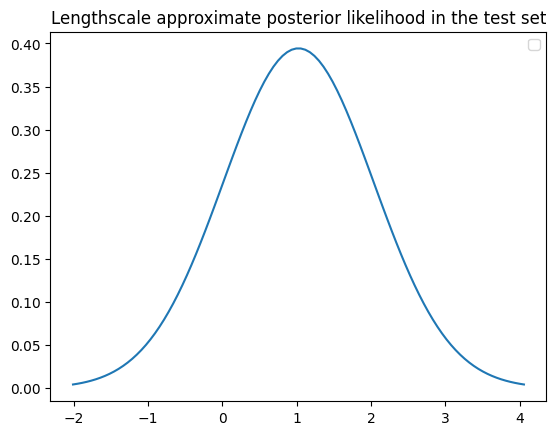

30.800281566547675
tensor(-364.6816, dtype=torch.float64)


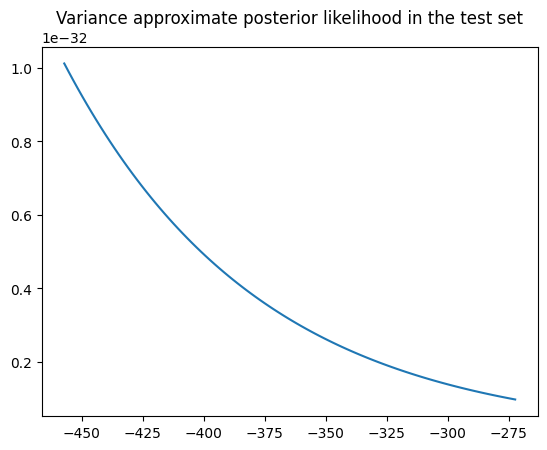

In [35]:
import math
from scipy import stats
sigma_ls = math.sqrt(lengthscale_mu_sample_var)
x = np.linspace(lengthscale_mu_sample_var - 3*sigma_ls, lengthscale_mu_sample_var + 3*sigma_ls, 100)
plt.plot(x, stats.norm.pdf(x, lengthscale_mu_sample_var, sigma_ls))
plt.title("Lengthscale approximate posterior likelihood in the test set")
plt.legend()
plt.show()

sigma_var = math.sqrt(variance_sigma_sample_var)
x_var = np.linspace(variance_mu_sample_var - 3*sigma_var, variance_mu_sample_var + 3*sigma_var, 100)
plt.plot(x_var, stats.norm.pdf(x, variance_mu_sample_var, sigma_var))
plt.title("Variance approximate posterior likelihood in the test set")
plt.show()